##Imports necessários


In [1]:
import numpy as np
import torch
from bs4 import BeautifulSoup
from torch import nn
import torch.nn.functional as F
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk import pos_tag
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from torch.utils.data import DataLoader, TensorDataset

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

## Carregando os dados


In [4]:
from google.colab import drive
import pandas as pd
drive.mount('/content/drive/')
import sys
#sys.path.append('/content/drive/My Drive/Colab Notebooks')
caminho_dir = './'
#caminho_dir = '/content/drive/MyDrive/Colab Notebooks/Datasets/sorted_data'
# caminho_dir_ricardo = '/content/drive/MyDrive/Raiz/Faculdade/2021.2/Deep Learning/RNNs_Trabalho_3/sorted_data'
# caminho_dir_ricardo_2 = '/content/drive/MyDrive/@ufg.br/Faculdade/2021.2/Deep Learning/RNNs_Trabalho_3/sorted_data'
#caminho_dir_ricardo = caminho_dir_ricardo_2

# open text file and read in data as `text`
with open('/{}/electronics/all.review'.format(caminho_dir), 'r',encoding = 'unicode_escape') as f:
    electronics = f.read()

with open('{}/kitchen_&_housewares/all.review'.format(caminho_dir), 'r',encoding = 'unicode_escape') as f:
    kitchen = f.read()    

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Carregando os dados de rating e review do arquivo e selecionando apenas as strings


In [5]:
data_electronics = BeautifulSoup(electronics, 'xml')
ratings_electronics = data_electronics.find_all('rating')
ratings_electronics[:] = [rating.string for rating in ratings_electronics]
reviews_electronics = data_electronics.find_all('review_text')
reviews_electronics[:] = [review.string for review in reviews_electronics]

data_kitchen = BeautifulSoup(kitchen, 'xml')
ratings_kitchen = data_kitchen.find_all('rating')
ratings_kitchen[:] = [rating.string for rating in ratings_kitchen]
reviews_kitchen = data_kitchen.find_all('review_text')
reviews_kitchen[:] = [review.string for review in reviews_kitchen]

Tratando as strings de review e rating


In [6]:
for ch in ['\n','!','"',"'",'(',')',',','.0','-','.','/',':',';','?',"  "]:
  ratings_electronics[:] = [rating.replace(ch,"") for rating in ratings_electronics]
  reviews_electronics[:] = [review.replace(ch," ") for review in reviews_electronics]
  ratings_kitchen[:] = [rating.replace(ch,"") for rating in ratings_kitchen]
  reviews_kitchen[:] = [review.replace(ch," ") for review in reviews_kitchen]


Coletando o valor inteiro do rating

In [7]:
ratings_electronics[:] = [int(rating) for rating in ratings_electronics]
ratings_kitchen[:] = [int(rating) for rating in ratings_kitchen]

Ajustando a quantidade de labels

In [8]:
import pandas as pd
print('Kitchen n_class: {}, sendo elas:{}'.format(len(pd.Series(ratings_kitchen).unique()),sorted(pd.Series(ratings_kitchen).unique())))
print('Electronics n_class: {}, sendo elas:{}'.format(len(pd.Series(ratings_electronics).unique()),sorted(pd.Series(ratings_electronics).unique())))


Kitchen n_class: 4, sendo elas:[1, 2, 4, 5]
Electronics n_class: 4, sendo elas:[1, 2, 4, 5]


In [9]:
ratings_electronics = [(rating - 2) if rating > 2  else (rating - 1) for rating in ratings_electronics]
ratings_kitchen = [(rating - 2) if rating > 2  else (rating - 1) for rating in ratings_kitchen]
print('Electronics n_class: {}, sendo elas:{}'.format(len(pd.Series(ratings_electronics).unique()),sorted(pd.Series(ratings_electronics).unique())))
print('Kitchen n_class: {}, sendo elas:{}'.format(len(pd.Series(ratings_kitchen).unique()),sorted(pd.Series(ratings_kitchen).unique())))


Electronics n_class: 4, sendo elas:[0, 1, 2, 3]
Kitchen n_class: 4, sendo elas:[0, 1, 2, 3]


In [10]:
#Foram realizados testes com 4 classes, porém devido a quantidade e desbalanceamento dos dados nas bases utilizadas, a rede alcançou uma acurácia preditiva baixa. 
#Desta forma, serão reduzidas a quantidade de classes para 3, unificando as classificações com rating 0 e 1 representando classificações "ruins"
ratings_electronics = [(rating - 1) if (rating > 0) else rating for rating in ratings_electronics]
ratings_kitchen = [(rating - 1) if rating > 1 else rating for rating in ratings_kitchen]
print('Electronics n_class: {}, sendo elas:{}'.format(len(pd.Series(ratings_electronics).unique()),sorted(pd.Series(ratings_electronics).unique())))
print('Kitchen n_class: {}, sendo elas:{}'.format(len(pd.Series(ratings_kitchen).unique()),sorted(pd.Series(ratings_kitchen).unique())))


Electronics n_class: 3, sendo elas:[0, 1, 2]
Kitchen n_class: 3, sendo elas:[0, 1, 2]


Deixando as reviews em minúsculo

In [11]:
for index, value in enumerate(reviews_electronics): 
    reviews_electronics[index] = value.lower()

for index, value in enumerate(reviews_kitchen): 
    reviews_kitchen[index] = value.lower()    

print('Quantidade de reviews ELETRONICS:',len(reviews_electronics))
print('Quantidade de ratings ELETRONICS:',len(ratings_electronics))

print('Quantidade de reviews KITCHEN:',len(reviews_kitchen))
print('Quantidade de ratings KITCHEN:',len(ratings_kitchen))

Quantidade de reviews ELETRONICS: 23009
Quantidade de ratings ELETRONICS: 23009
Quantidade de reviews KITCHEN: 19856
Quantidade de ratings KITCHEN: 19856


### Tokenization




In [12]:
#Gera uma lista com tornando a cada '-'(parametro de separação entre as palavras) do "joined" em um item do array
joinedReviews_electronics = '-'.join(reviews_electronics)
words_electronics = word_tokenize(joinedReviews_electronics)

joinedReviews_kitchen = '-'.join(reviews_kitchen)
words_kitchen = word_tokenize(joinedReviews_kitchen)
print(words_kitchen[:100])

['i', 've', 'been', 'through', 'four', 'of', 'these', 'expensive', 'units', 'they', 'work', 'great', 'on', 'my', 'great', 'pyrenees', 'dog', 'at', 'least', 'they', 'work', 'for', 'awhile', 'then', 'i', 'end', 'up', 'trying', 'to', 'figure', 'out', 'if', 'the', 'batteries', 'are', 'dead', 'then', 'if', 'the', 'new', 'batteries', 'i', 'put', 'in', 'were', 'dead', 'to', 'begin', 'with', 'and', 'then', 'i', 'send', 'it', 'back', 'for', 'repair', 'once', 'i', 'got', 'back', 'a', 'unit', 'that', 'worked', 'again', 'for', 'awhile', 'then', 'i', 'got', 'back', 'a', 'unit', 'that', 'never', 'worked', 'again', 'i', 'stopped', 'sending', 'in', 'my', 'broken', 'units', 'after', 'that', 'so', 'in', 'desperation', 'and', 'impending', 'poverty', 'i', 'switched', 'to', 'a', 'shock', 'collar', 'it']


##Stop words

In [13]:
#remove um grupo especial de palavras ("stop words") do idioma setado (english) definido pela bilbioteca "stopwords" .
stop_words = stopwords.words('english')
filtered_words_electronics = [word for word in words_electronics if word not in stop_words]
filtered_words_kitchen = [word for word in words_kitchen if word not in stop_words]
#os itens removidos podem ser verificados ao "printar" a varíavel stop_words

##Stemming

In [15]:
#Remove os radicais das palavras, mantendo apenas as raízes (núcleo semântico).
porter = PorterStemmer()
stemmed_electronics = [porter.stem(word) for word in filtered_words_electronics]
stemmed_kitchen = [porter.stem(word) for word in filtered_words_kitchen]


In [16]:
(9840/25783)*100

38.16468215490828

##Relação das palavras entre as duas bases

In [17]:
print("Quantidade de palavras em comum:", len(set(stemmed_electronics) & set(stemmed_kitchen)))
print("Quantidade de palavras únicas:", len(set(stemmed_electronics).symmetric_difference(stemmed_kitchen)))
print("Quantidade de palavras exclusivas electronics:",len(set(stemmed_electronics).difference(stemmed_kitchen)))
print("Quantidade de palavras exclusivas kitchen:",len(set(stemmed_kitchen).difference(stemmed_electronics)))

Quantidade de palavras em comum: 9840
Quantidade de palavras únicas: 24826
Quantidade de palavras exclusivas electronics: 15943
Quantidade de palavras exclusivas kitchen: 8883


##Recriando a lista de reviews

In [18]:
all_text_electronics = ' '.join(stemmed_electronics)
reviews_split_electronics = all_text_electronics.split('-')

all_text_kitchen = ' '.join(stemmed_kitchen)
reviews_split_kitchen = all_text_kitchen.split('-')

print(len(reviews_split_electronics))
print(len(reviews_split_kitchen))



23009
19856


##Mapeando o dicionário de vocab para Int

In [19]:
all_text2_electronics = ' '.join(reviews_split_electronics)
words_electronics = all_text2_electronics.split()
count_words_electronics = Counter(words_electronics)

total_words_electronics = len(words_electronics)
sorted_words_electronics = count_words_electronics.most_common(total_words_electronics)
vocab_to_int_electronics = {w:i+1 for i, (w,c) in enumerate(sorted_words_electronics)}
int_to_vocab_electronics = {value:key for key,value in vocab_to_int_electronics.items()}

all_text2_kitchen = ' '.join(reviews_split_kitchen)
words_kitchen = all_text2_kitchen.split()
count_words_kitchen = Counter(words_kitchen)

total_words_kitchen = len(words_kitchen)
sorted_words_kitchen = count_words_kitchen.most_common(total_words_kitchen)
vocab_to_int_kitchen = {w:i+1 for i, (w,c) in enumerate(sorted_words_kitchen)}
int_to_vocab_kitchen = {value:key for key,value in vocab_to_int_kitchen.items()}



In [ ]:
# from enum import unique
# #"Traduzindo" o dict electronics para os valores do kitchen

# vocab_to_int_electronics_translated = {}
# uniques = []
# for i,word in enumerate(vocab_to_int_electronics):
#   if word in count_words_kitchen.keys():
#      vocab_to_int_electronics_translated[word] = vocab_to_int_kitchen[word]
#   else:
#       uniques.append(word)
#     #Tratamento das palavras unicas do vocabulário electronics
#     # vocab_to_int_electronics_translated[word] = len(vocab_to_int_electronics_translated) + cont
#     # cont += 1

# #Coleta o atual valor máximo do dict, para evitar repetições, os valores adicionados a partir deste ponto, partirao daqui.
# import operator
# max_key = max(vocab_to_int_electronics_translated.items(), key=operator.itemgetter(1))[0]
# max_value = vocab_to_int_electronics_translated[max_key]
# cont = 0

# for word in uniques:
#   cont += 1
#   vocab_to_int_electronics_translated[word] = max_value + cont

# # print(len(vocab_to_int_electronics) - len(vocab_to_int_electronics_translated))

In [22]:
print (count_words_electronics)
print (vocab_to_int_electronics)
print (int_to_vocab_electronics)
print ('\n')
print (count_words_kitchen)
print (vocab_to_int_kitchen)
print (int_to_vocab_kitchen)

Counter({'use': 15993, 'work': 11608, 'one': 10503, 'great': 8956, 'get': 7859, 'good': 7417, 'sound': 7176, 'like': 6861, 'product': 6779, 'would': 6734, 'time': 5797, 'well': 5354, 'qualiti': 4990, 'need': 4944, 'problem': 4934, 'look': 4865, 'buy': 4840, 'also': 4761, 'price': 4660, 'card': 4549, 'unit': 4518, 'bought': 4451, 'cabl': 4315, 'set': 4290, 'player': 4038, 'even': 4028, 'make': 3967, 'want': 3958, 'purchas': 3894, 'tv': 3861, '2': 3833, 'go': 3793, 'much': 3687, 'easi': 3667, 'dvd': 3634, 'realli': 3616, 'better': 3473, 'batteri': 3456, 'thing': 3413, 'ipod': 3360, 'tri': 3302, '$': 3296, 'speaker': 3292, 'case': 3284, 'littl': 3281, 'back': 3238, 'comput': 3199, 'review': 3039, 'first': 2997, 'cd': 2992, 'system': 2972, 'radio': 2970, '1': 2930, 'two': 2896, 'got': 2873, 'year': 2837, 'could': 2815, 'recommend': 2799, 'power': 2790, 'connect': 2790, 'take': 2776, 'new': 2726, 'come': 2707, 'play': 2693, 'pictur': 2679, 'way': 2661, 'nice': 2657, '3': 2561, '5': 2511, 's

In [28]:
file1 = open("/content/drive/MyDrive/Colab Notebooks/dict_electronics.txt", "w") 
file1.write("%s = %s\n\n\n ~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~# \n\n\n" %("dict_electronics (vocab_to_int): ", vocab_to_int_electronics))
file1.write("%s = %s\n" %("dict_electronics (int_to_vocab): ",int_to_vocab_electronics))
file1.close()

file2 = open("/content/drive/MyDrive/Colab Notebooks/dict_kitchen.txt", "w") 
file2.write("%s = %s\n\n\n ~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~#~# \n\n\n" %("dict_kitchen (vocab_to_int): ", vocab_to_int_kitchen))
file2.write("%s = %s\n" %("dict_electronics (int_to_vocab): ",int_to_vocab_kitchen))
file2.close()


##Codificando as palavras

In [29]:
reviews_int_electronics = []
for review in reviews_split_electronics :
    r = [vocab_to_int_electronics [w] for w in review.split()]
    reviews_int_electronics .append(r)
print (reviews_int_electronics [0:3])

reviews_int_kitchen = []
for review in reviews_split_kitchen :
    r = [vocab_to_int_kitchen [w] for w in review.split()]
    reviews_int_kitchen .append(r)
print (reviews_int_kitchen [0:3])


[[22, 169, 336, 21, 3, 784, 315, 516, 169, 51, 35, 25, 1008, 127, 189, 211, 616, 815, 26, 2685, 2438, 211, 7, 13, 67, 19, 109, 25, 2, 1311, 719, 316, 1213, 19, 244], [1, 838, 425, 35, 666, 139, 69, 482, 228, 71, 55, 62, 71, 608, 49, 211, 62, 346, 838, 22, 482, 900, 94, 48, 582, 3784, 186, 530, 102, 218, 62, 334, 658, 388, 513, 1126, 120, 1312, 308, 9211, 110, 1880, 113, 76, 17, 252, 826], [22, 211, 3067, 14, 55, 3, 146, 505, 12, 10990, 6, 838, 645, 69, 211, 55, 3, 372, 6, 33, 1445, 645, 372, 116, 211, 115, 872, 494, 1514, 4678, 8056, 7324, 211, 27, 1541, 430, 900, 8, 885, 44, 17, 246, 228, 872, 141, 6, 9]]
[[466, 200, 80, 8, 3, 3, 7454, 115, 291, 8, 1714, 180, 41, 558, 406, 1500, 73, 406, 42, 1500, 973, 515, 62, 986, 55, 62, 80, 8, 1714, 55, 62, 80, 82, 8, 261, 515, 393, 80, 2263, 8694, 8695, 502, 1095, 480, 386, 5632, 246, 706, 475, 667, 19, 8, 477, 41, 233, 4982, 8696, 1095, 480, 388, 417, 3857, 480, 291, 587, 1051, 21, 119], [508, 541, 527, 9, 7, 102, 572, 419, 268, 406, 210, 542, 4

##Analisando os dados em Reviews Electronics

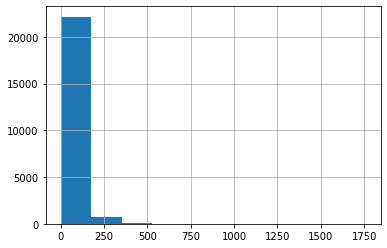

count    23009.000000
mean        51.773610
std         60.261041
min          1.000000
25%         19.000000
50%         34.000000
75%         61.000000
max       1757.000000
dtype: float64

In [30]:
reviews_len_electronics = [len(x) for x in reviews_int_electronics]
pd.Series(reviews_len_electronics).hist()
plt.show()
pd.Series(reviews_len_electronics).describe()


(array([ 5048.,     0.,     0.,     0.,  5511.,     0.,     0., 12450.]),
 array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  ]),
 <a list of 8 Patch objects>)

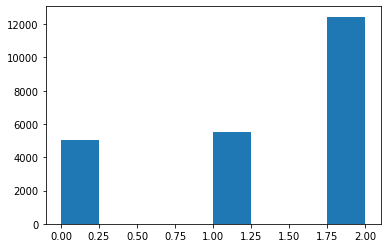

In [31]:
plt.hist(ratings_electronics,bins=8)


##Analisando os dados em Reviews Kitchen & Housewares

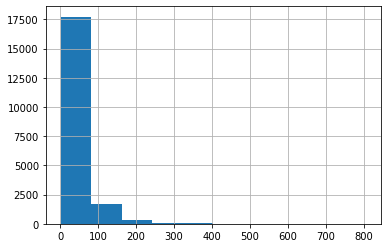

count    19856.000000
mean        42.951501
std         45.379710
min          2.000000
25%         17.000000
50%         30.000000
75%         52.000000
max        805.000000
dtype: float64

In [32]:
reviews_len_kitchen = [len(x) for x in reviews_int_kitchen]
pd.Series(reviews_len_kitchen).hist()
plt.show()
pd.Series(reviews_len_kitchen).describe()

(array([ 2716.,     0.,     0.,     0.,  5487.,     0.,     0., 11653.]),
 array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  ]),
 <a list of 8 Patch objects>)

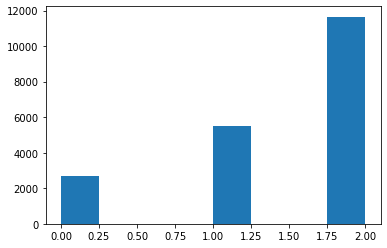

In [33]:
plt.hist(ratings_kitchen,bins=8)


## Outliers

In [34]:
#removendo casos em que a avaliação possuí menos de 2 letras
reviews_int_kitchen = [reviews_int_kitchen[i] for i,l in enumerate(reviews_len_kitchen) if l > 1]
reviews_int_electronics = [reviews_int_electronics[i] for i,l in enumerate(reviews_len_electronics) if l > 1 ]
ratings_kitchen = [ratings_kitchen[i] for i,l in enumerate(reviews_len_kitchen) if l > 1]
ratings_electronics = [ratings_electronics[i] for i,l in enumerate(reviews_len_electronics) if l > 1]


reviews_len_electronics = [len(x) for x in reviews_int_electronics]
reviews_len_kitchen = [len(x) for x in reviews_int_kitchen]

print('Eletronic min: {}'.format(min(reviews_len_kitchen)))
print('Eletronic min: {}'.format(min(reviews_len_electronics)))


Eletronic min: 2
Eletronic min: 2


##Padding/Truncating

In [35]:
def pad_features(reviews_int, seq_length):
    features = np.zeros((len(reviews_int), seq_length), dtype = int)
    
    for i, review in enumerate(reviews_int):
        review_len = len(review)
        
        if review_len <= seq_length:
            zeroes = list(np.zeros(seq_length-review_len))
            new = zeroes+review
        elif review_len > seq_length:
            new = review[0:seq_length]
        
        features[i,:] = np.array(new)
    
    return features

In [36]:
features_electronics = pad_features(reviews_int_electronics, 50)
print (len(features_electronics))
print (len(ratings_electronics))

features_kitchen = pad_features(reviews_int_kitchen, 50)
print (len(features_kitchen))
print (len(ratings_kitchen))

23005
23005
19856
19856


In [37]:
features_kitchen

array([[  466,   200,    80, ...,   706,   475,   667],
       [    0,     0,     0, ...,   924,   112,  3532],
       [    0,     0,     0, ...,    36,    78,   244],
       ...,
       [  311, 18720,  8334, ...,   460,   291,  1672],
       [   13,    49,     5, ...,   244,   838,   548],
       [   28,   898,   385, ...,   898,   642,   510]])

##Separando em datasets de treino(80%), validação(10%) e teste(10%)



In [38]:
split_frac = 0.8
len_feat_electronics = len(features_electronics)
len_feat_kitchen = len(features_kitchen)

train_x_electronics = features_electronics[0:int(split_frac*len_feat_electronics)]
train_y_electronics = ratings_electronics[0:int(split_frac*len_feat_electronics)]
remaining_x_electronics = features_electronics[int(split_frac*len_feat_electronics):]
remaining_y_electronics = ratings_electronics[int(split_frac*len_feat_electronics):]
valid_x_electronics = remaining_x_electronics[0:int(len(remaining_x_electronics)*0.5)]
valid_y_electronics = remaining_y_electronics[0:int(len(remaining_y_electronics)*0.5)]
test_x_electronics = remaining_x_electronics[int(len(remaining_x_electronics)*0.5):]
test_y_electronics = remaining_y_electronics[int(len(remaining_y_electronics)*0.5):]

train_x_kitchen = features_kitchen[0:int(split_frac*len_feat_kitchen)]
train_y_kitchen= ratings_kitchen[0:int(split_frac*len_feat_kitchen)]
remaining_x_kitchen = features_kitchen[int(split_frac*len_feat_kitchen):]
remaining_y_kitchen = ratings_kitchen[int(split_frac*len_feat_kitchen):]
valid_x_kitchen = remaining_x_kitchen[0:int(len(remaining_x_kitchen)*0.5)]
valid_y_kitchen = remaining_y_kitchen[0:int(len(remaining_y_kitchen)*0.5)]
test_x_kitchen = remaining_x_kitchen[int(len(remaining_x_kitchen)*0.5):]
test_y_kitchen = remaining_y_kitchen[int(len(remaining_y_kitchen)*0.5):]



In [39]:
len(valid_y_electronics)

2300

##Dataloaders e Batching

In [40]:
#Tensor datasets
train_data_electronics = TensorDataset(torch.from_numpy(np.array(train_x_electronics)), torch.from_numpy(np.array(train_y_electronics)))
valid_data_electronics = TensorDataset(torch.from_numpy(np.array(valid_x_electronics)), torch.from_numpy(np.array(valid_y_electronics)))
test_data_electronics = TensorDataset(torch.from_numpy(np.array(test_x_electronics)), torch.from_numpy(np.array(test_y_electronics)))
# dataloaders
batch_size = 50
train_electronics = DataLoader(train_data_electronics, shuffle=True, batch_size=batch_size)
valid_electronics = DataLoader(valid_data_electronics, shuffle=True, batch_size=batch_size)
test_electronics = DataLoader(test_data_electronics, shuffle=True, batch_size=batch_size)

#Tensor datasets
train_data_kitchen = TensorDataset(torch.from_numpy(np.array(train_x_kitchen)), torch.from_numpy(np.array(train_y_kitchen)))
valid_data_kitchen = TensorDataset(torch.from_numpy(np.array(valid_x_kitchen)), torch.from_numpy(np.array(valid_y_kitchen)))
test_data_kitchen = TensorDataset(torch.from_numpy(np.array(test_x_kitchen)), torch.from_numpy(np.array(test_y_kitchen)))
# dataloaders
batch_size = 50
train_kitchen = DataLoader(train_data_kitchen, shuffle=True, batch_size=batch_size)
valid_kitchen = DataLoader(valid_data_kitchen, shuffle=True, batch_size=batch_size)
test_kitchen = DataLoader(test_data_kitchen, shuffle=True, batch_size=batch_size)

In [ ]:
# obtain one batch of training data
dataiter = iter(train_electronics)
sample_x, sample_y = dataiter.next()
print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print()
print('Sample label size: ', sample_y.size()) # batch_size
print('Sample label: \n', sample_y)

In [ ]:
# obtain one batch of training data
dataiter = iter(train_kitchen)
sample_x, sample_y = dataiter.next()
print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print()
print('Sample label size: ', sample_y.size()) # batch_size
print('Sample label: \n', sample_y)

---
# Modelo e treinamento


### Base 1: kitchen reviews

In [ ]:
# check if GPU is available
train_on_gpu = torch.cuda.is_available()
if(train_on_gpu):
    print('Training on GPU!')
else: 
    print('No GPU available, training on CPU; consider making n_epochs very small.')

In [ ]:
import torch.nn as nn

class SentimentRNN(nn.Module):
    """
    The RNN model that will be used to perform Sentiment analysis.
    """

    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, activation,emb_layer,drop_prob=0.7):
        """
        Initialize the model by setting up the layers.
        """
        super(SentimentRNN, self).__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        # define all layers
        #Embbed_layer
        self.embbed = emb_layer

        #LSTM_layer
        self.lstm = nn.LSTM(embedding_dim,hidden_dim,n_layers,
                            dropout=drop_prob,batch_first=True)
        #Dropout
        self.dropout = nn.Dropout(drop_prob)
        
        #Fc_layer
        self.fc = nn.Linear(hidden_dim,output_size)

        #Camada de não linearidade 
        self.act = activation

    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)
        x = x.long()
        embeds = self.embbed(x)
        lstm_out,hidden = self.lstm(embeds)
        #reshape dos dados
        lstm_out = lstm_out[:,-1,:]
  
        out = self.dropout(lstm_out)
        out = self.fc(out)

        act_out = self.act(out)

        return act_out, hidden  
    
    #Inicializando a camada oculta
    def init_hidden(self, batch_size):
       weight = next(self.parameters()).data
        
       if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
       else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        
       return hidden
        

#### Training

In [ ]:
def training(net,n_epochs,clip,train_data_set,valid_data_set,caminho_model,model_name):    
    
  net.train()
  counter = 0

  #Training
  valid_loss_min = np.Inf # track change in validation loss
  train_loss = 0.0
  valid_loss = 0.0  
  train_errors = []
  valid_errors = []
  if(train_on_gpu):
    net.cuda()
  
  for e in range(n_epochs):
    h = net.init_hidden(batch_size)

    #batch_loop
    for inputs,labels in train_data_set:
      if(train_on_gpu):
        inputs, labels = inputs.cuda(),labels.cuda() 
    
      #Separa o valor atual do estado oculto de seu histórico
      h = tuple([each.data for each in h])

      #zera o gradiente acumulado
      net.zero_grad()
      output,h = net(inputs,h)

      #Error
      loss = criterion(output.squeeze(),labels.long())
      train_loss += loss.item()*inputs.size(0)
      #loss = criterion(output,labels.float())
      loss.backward()
      
      nn.utils.clip_grad_norm_(net.parameters(), clip)
      optimizer.step()


      counter += 1
    #coleta os erros de treino
    #Status do erro associado
      #if counter % print_every == 0:
    val_h = net.init_hidden(batch_size)
    net.eval()
    #Neste ponto é calculado o erro de validação para que, com base neste, seja salvo o modelo que melhor generalizar a solução para o problema (menor valid_loss)
    for inputs, labels in valid_data_set:
        val_h = tuple([each.data for each in val_h])

        if(train_on_gpu):
          inputs,labels = inputs.cuda(), labels.cuda()
        try:  
          #Insere os dados de validação na rede
          output, val_h  = net(inputs,val_h)
          #verifica o erro associado
          val_loss = criterion(output.squeeze(), labels.long())
          valid_loss += val_loss.item()*inputs.size(0)
        except IndexError: 
          print('IndexError')
          print(inputs.size())
      
    #coleta os erros de validacao
    #Calculando o erro médio
    train_loss = train_loss/len(train_data_set.sampler)
    valid_loss = valid_loss/len(valid_data_set.sampler)
    train_errors.append(train_loss)
    valid_errors.append(valid_loss)


    net.train()
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(e, train_loss, valid_loss))
    
    if valid_loss <= valid_loss_min:
      print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
      valid_loss_min,
      valid_loss))
      torch.save(net.state_dict(), '{}/models/{}'.format(caminho_model,model_name))
      valid_loss_min = valid_loss

  return train_errors,valid_errors

Teste de acurácia

In [ ]:
def accuracy_pontuation(data_set, net):
  classes = ['Negative','Neutral','Positive']

  # track test loss
  test_loss = 0.0
  class_correct = list(0. for i in range(len(classes)))
  class_total = list(0. for i in range(len(classes)))
  net.eval()
  # iterate over test data
  h = net.init_hidden(batch_size)
  for data, target in data_set:
      h = tuple([each.data for each in h])
      # move tensors to GPU if CUDA is available
      if train_on_gpu:
          data, target = data.cuda(), target.cuda()
      try:
        # forward pass: compute predicted outputs by passing inputs to the model
        output,h = net(data, h)
        # calculate the batch loss
        loss = criterion(output, target)
        # update test loss 
        test_loss += loss.item()*data.size(0)
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)    
        # compare predictions to true label
        correct_tensor = pred.eq(target.data.view_as(pred))
        correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
        # calculate test accuracy for each object class
        for i in range(batch_size):
          try:
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1
          except:
            pass
      except IndexError:
           print('Erro de index')
           print(data.size())

  # average test loss
  test_loss = test_loss/len(data_set.dataset)
  print('Test Loss: {:.6f}\n'.format(test_loss))
  class_pontuation = []
  for i in range(0,len(classes)):
      if class_total[i] > 0:
          print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
              classes[i], 100 * class_correct[i] / class_total[i],
              np.sum(class_correct[i]), np.sum(class_total[i])))
          class_pontuation.append((100 * class_correct[i] / class_total[i]))
      else:
          print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

  print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
      100. * np.sum(class_correct) / np.sum(class_total),
      np.sum(class_correct), np.sum(class_total)))
  class_pontuation.append((100. * np.sum(class_correct) / np.sum(class_total)))
  return class_pontuation

Instanciando a rede

In [ ]:
vocab_size = len(vocab_to_int_kitchen) + 1
out_size = 3
embedding_dim = 256
hidden_dim = 256
n_layers = 2

net2 = SentimentRNN(vocab_size,output_size=out_size,embedding_dim= embedding_dim,hidden_dim = hidden_dim, 
                      n_layers = n_layers,activation = nn.ReLU(),emb_layer=nn.Embedding(vocab_size,embedding_dim))
if(train_on_gpu):
  net2.cuda()
print(net2)

Como há um grande desbalanceamento na base de dados, tendo muito mais dados da classe de sentimento positivo que os demais, será aplicada uma técnica simples na tentativa de mitigar este problema, a qual consiste na inserção de pesos para cada classe no momento em que o erro for calculado, de modo que, classes com uma menor quantidade de dados obterão pesos maiores com relação as classes majoritárias do dataset. Desta maneira, no momento do calculo do erro, a rede buscará com mais eficiência diminuir o erro das classes minoritárias, tornando a classificação mais homogênea.  

In [ ]:
total_dataset = len(reviews_int_kitchen)

class_0 = pd.Series(ratings_kitchen).value_counts()[pd.Series(ratings_kitchen).value_counts().index == 0].values
class_1 = pd.Series(ratings_kitchen).value_counts()[pd.Series(ratings_kitchen).value_counts().index == 1].values
class_2 = pd.Series(ratings_kitchen).value_counts()[pd.Series(ratings_kitchen).value_counts().index == 2].values

weigths_kitchen_np = [(1/class_0[0])*total_dataset,(1/class_1[0])*total_dataset,(1/class_2[0])*total_dataset]
weigths_kitchen = torch.tensor(weigths_kitchen_np)
weigths_kitchen
if train_on_gpu:
  weigths_kitchen = weigths_kitchen.cuda()

In [ ]:
weigths_kitchen

In [ ]:
#Definindo pessos
n_epochs = 10
caminho_model = './models'
caminho_model_2 = '/content/drive/MyDrive/@ufg.br/Faculdade/2021.2/Deep Learning/RNNs_Trabalho_3'
#caminho_model = caminho_model_2
criterion = nn.CrossEntropyLoss(weight=weigths_kitchen.float())
optimizer = torch.optim.Adam(net2.parameters(), lr=3e-4)


In [ ]:
n2_train_loss, n2_valid_loss = training(net=net2,n_epochs = n_epochs,clip = 5,train_data_set = train_kitchen,
                          valid_data_set = valid_kitchen,caminho_model = caminho_model,model_name='2_Model_1.pt')

In [ ]:
net2.load_state_dict(torch.load('{}/models/2_Model_1.pt'.format(caminho_model),map_location=torch.device('cpu')))

In [ ]:
accuracy_net2 = accuracy_pontuation(test_kitchen,net2)


## Utilizando o primeiro modelo para transferência de aprendizado com a base electronics (#Parte 3)

## Gerando uma embedding layer, a partir dos pesos encontrados no treinamento da primeira base

Primeiramente, é preciso considerar que a embedding layer, da rede anterior, foi treinada com base em uma outra base de dados, apresentando para sua adaptações os seguintes problemas:
* Os valores de vocab_int são distintos
* Há palavras únicas do segundo dataset.

Para a primeira parte, basta coletarmos para cada palavra, o valor equivalente passando o parametro vocab_to_int_kitchen[word] como entrada na camada de embedding pré treinada.

Para a segunda, caso a palavra seja única do segundo dataset, será inserido um valor aleatório de pesos para seu preenchimento

In [ ]:
embedding_layer = net2.embbed.cpu()
embedding_layer.weight.requires_grad = False #"Congela" o treinamento da camada

#Criando uma matriz que irá conter os pesos da camada de embedding
len_matriz = (len(vocab_to_int_electronics)+1)
embedding_weigths = np.zeros((len_matriz,embedding_dim))

for i,word in enumerate(vocab_to_int_electronics):
  try:
    #Coleta o valor do peso treinado caso encontre o mesmo na embedding_layer
    embedding_weigths[i] = embedding_layer(torch.tensor(vocab_to_int_kitchen[word]))
  except:
    #Caso a palavra seja única, só exista em um dos dois vocabulários, é inserido o um valor aleatório
    embedding_weigths[i] = np.random.normal(0.5,size=(embedding_dim))



In [ ]:
#Inserção de pesos aleatórios para o valor 0 que não é listado
embedding_weigths[len(embedding_weigths)-1] = np.random.normal(0.5,size=(embedding_dim))

In [ ]:
#Função geradora da camadas
def embedding_pre_trained(embedding_weigths,trainable=False):
  embedding_weigths = torch.tensor(embedding_weigths)
  vocab_size, embedding_dim = embedding_weigths.size()
  emb_layer = nn.Embedding(vocab_size ,embedding_dim)
  
  #Carrega o "estado" da camada com os pesos coletados da embeding layer da rede já treinada 
  emb_layer.load_state_dict({'weight':embedding_weigths})
  
  #Congela o treinamento da camada
  if trainable == False:
     emb_layer.weight.requires_grad = False
  else:
    emb_layer.weight.requires_grad = True
    print(emb_layer.weight.requires_grad)

  return emb_layer


vocab_size = len(reviews_int_electronics) + 1
out_size = 3
hidden_dim = 256
n_layers = 2

net_3 = SentimentRNN(vocab_size,output_size=out_size,embedding_dim= embedding_dim,hidden_dim = hidden_dim, 
                     n_layers = n_layers,activation = nn.ReLU(),emb_layer=embedding_pre_trained(embedding_weigths,False))
#net_3.embbed.weight.requires_grad = False
if(train_on_gpu):
  net_3.cuda()

print(net_3)

In [ ]:
#Definindo os pesos das classes para "compensar" o desbalanceamento da base de dados

total_dataset_elec = len(reviews_int_electronics)

class_0 = pd.Series(ratings_electronics).value_counts()[pd.Series(ratings_electronics).value_counts().index == 0].values
class_1 = pd.Series(ratings_electronics).value_counts()[pd.Series(ratings_electronics).value_counts().index == 1].values
class_2 = pd.Series(ratings_electronics).value_counts()[pd.Series(ratings_electronics).value_counts().index == 2].values


weigths_elec_np = [(1/class_0[0])*total_dataset_elec,(1/class_1[0])*total_dataset_elec,(1/class_2[0])*total_dataset_elec]
weigths_elec = torch.tensor(weigths_elec_np)
if train_on_gpu:
  weigths_elec = weigths_elec.cuda()

In [ ]:

criterion = nn.CrossEntropyLoss(weight = weigths_elec.float())
optimizer = torch.optim.Adam(net_3.parameters(), lr=3e-4)


In [ ]:
#Treinando a rede 
n3_train_loss, n3_valid_loss = training(net=net_3,n_epochs = n_epochs,clip = 5,train_data_set = train_electronics,valid_data_set = valid_electronics,
   caminho_model = caminho_model,model_name = '2_Model_2.pt')

In [ ]:
net_3.load_state_dict(torch.load('{}/models/2_Model_2.pt'.format(caminho_model)))


In [ ]:
accuracy_net_3 = accuracy_pontuation(test_electronics,net_3)

## Liberando o treinamento da camada de embedding

In [ ]:
vocab_size = len(vocab_to_int_electronics) + 1
out_size = 3
hidden_dim = 256
n_layers = 2

net_4 = SentimentRNN(vocab_size,output_size=out_size,embedding_dim= embedding_dim,hidden_dim = hidden_dim, 
                     n_layers = n_layers,activation = nn.ReLU(),emb_layer=embedding_pre_trained(embedding_weigths,trainable = True))
#net_3.embbed.weight.requires_grad = False
if(train_on_gpu):
  net_4.cuda()
print(net_4)

In [ ]:

criterion = nn.CrossEntropyLoss(weight = weigths_elec.float())
optimizer = torch.optim.Adam(net_4.parameters(), lr=3e-4)

In [ ]:
#Treinando a rede 
n4_train_loss, n4_valid_loss = training(net=net_4,n_epochs = n_epochs,clip = 10,train_data_set = train_electronics,valid_data_set = valid_electronics,
   caminho_model = caminho_model,model_name = '2_Model_3.pt')

In [ ]:
net_4.load_state_dict(torch.load('{}/models/2_Model_3.pt'.format(caminho_model)))
accuracy_net_4 = accuracy_pontuation(test_electronics,net_4)

## Permitindo que a rede gere sua própria embedding layer

In [ ]:
vocab_size = len(vocab_to_int_electronics) + 1
out_size = 3
hidden_dim = 256
n_layers = 2

net_5 = SentimentRNN(vocab_size,output_size=out_size,embedding_dim= embedding_dim,hidden_dim = hidden_dim, 
                     n_layers = n_layers,activation = nn.ReLU(),emb_layer=nn.Embedding(vocab_size,embedding_dim))
#net_3.embbed.weight.requires_grad = False
if(train_on_gpu):
  net_5.cuda()
print(net_5)

In [ ]:

criterion = nn.CrossEntropyLoss(weight = weigths_elec.float())
optimizer = torch.optim.Adam(net_5.parameters(), lr=3e-4)


In [ ]:
#Treinando a rede 
n5_train_loss, n5_valid_loss = training(net=net_5,n_epochs = n_epochs,clip = 10,train_data_set = train_electronics,valid_data_set = valid_electronics,
   caminho_model = caminho_model,model_name = '2_Model_4.pt')

In [ ]:
net_5.load_state_dict(torch.load('{}/models/2_Model_4.pt'.format(caminho_model)))
accuracy_net_5 = accuracy_pontuation(test_electronics,net_5)

In [ ]:
plt.subplots(figsize=(18,6))
plt.plot(accuracy_net_3)
plt.plot(accuracy_net_4)
plt.plot(accuracy_net_5)
plt.legend(['Embedding pre-treinada','Embedding pre-treinada apredendo','Embedding do zero'])
plt.xlabel('Class', fontdict = {'fontsize': 16})
plt.ylabel('Accuracy',fontdict = {'fontsize':16})
plt.xticks([0,1,2,3])
plt.title('Accuracy',fontdict = {'fontsize': 28})
plt.show()

**LEGENDA DO EIXO X:**

0 - Negative, 1 - Neutral, 2 - Positive, 3 - Total_accuracy

In [ ]:
acurracy_total = pd.DataFrame()
acurracy_total = pd.concat([pd.DataFrame(accuracy_net_3), pd.DataFrame(accuracy_net_4), pd.DataFrame(accuracy_net_5)],axis=1)
acurracy_total.columns = ['Embedding pre-treinada','Embedding pre-treinada apredendo','Embedding do zero']
acurracy_total['Classe'] = ['Negative','Neutral','Positive','General']
acurracy_total[acurracy_total.columns[[3,0,1,2]]]


## Errors

### Train

In [ ]:
plt.subplots(figsize=(18,6))
plt.plot(n3_train_loss)
plt.plot(n4_train_loss)
plt.plot(n5_train_loss)
plt.legend(['Embedding pre-treinada','Embedding pre-treinada apredendo','Embedding do zero'])
plt.xlabel('Epoch', fontdict = {'fontsize': 16})
plt.ylabel('Error',fontdict = {'fontsize':16})
plt.title('Errors',fontdict = {'fontsize': 28})
plt.show()


### Valid

In [ ]:
plt.subplots(figsize=(18,6))
plt.plot(n3_valid_loss)
plt.plot(n4_valid_loss)
plt.plot(n5_valid_loss)
plt.legend(['Embedding pre-treinada','Embedding pre-treinada apredendo','Embedding do zero'])
plt.xlabel('Epoch', fontdict = {'fontsize': 16})
plt.ylabel('Error',fontdict = {'fontsize':16})
plt.title('Errors',fontdict = {'fontsize': 28})
plt.show()


## Referências:

* https://towardsdatascience.com/sentiment-analysis-using-lstm-step-by-step-50d074f09948

* https://medium.com/turing-talks/word-embedding-fazendo-o-computador-entender-o-significado-das-palavras-92fe22745057

* https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

* https://chatbotslife.com/using-transfer-learning-with-word-embeddings-for-text-classification-tasks-d16386251672   

* https://www.analyticsvidhya.com/blog/2020/03/pretrained-word-embeddings-nlp/

* https://medium.com/@martinpella/how-to-use-pre-trained-word-embeddings-in-pytorch-71ca59249f76

* https://towardsdatascience.com/handling-imbalanced-datasets-in-deep-learning-f48407a0e758?gi=1405cfeae567